### What is Anomaly?
 - In machine learning and data mining, anomaly detection is the task of identifying the rare items, events or observations which are suspicious and seem different from the majority of the data. 
 -  These anomalies can indicate some kind of problems such as bank fraud, medical problems, failure of industrial equipment, etc. 
 -  The anomaly detection has two major categories, the unsupervised anomaly detection where anomalies are detected in an unlabeled data and the supervised anomaly detection where anomalies are detected in the labelled data. 

 - Anomaly detection has been used in various data mining applications to find the anomalous activities present in the available data.
 - Here we will discuss how to detect anomalies present in the temperature data that is available in the time-series format. This data is captured from the sensors of an internal component of a large industrial machine.


In [5]:
#Dataset link :- https://www.kaggle.com/boltzmannbrain/nab

In [6]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as md
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Lambda, Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
import time

In [7]:
#Loading dataset
df =pd.read_csv("/content/drive/MyDrive/Anomaly_Detection/ambient_temperature_system_failure.csv")

In [8]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [9]:
#Shape of dataset
df.shape

(7267, 2)

In [10]:
#Summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [11]:
#Check missing values in dataset
df.isnull().sum()

timestamp    0
value        0
dtype: int64

<Figure size 1080x720 with 0 Axes>

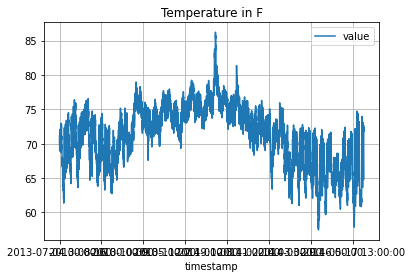

In [12]:
#Visualize the data
plt.figure(figsize = (15, 10))
df.plot(x = 'timestamp', y = 'value', title = 'Temperature in F')
plt.grid()

<Figure size 864x576 with 0 Axes>

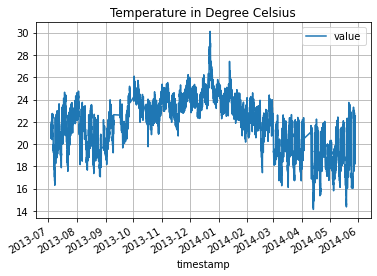

In [14]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp']) #converting timestamp to datetime
df['value'] = (df['value'] - 32) * 5/9 #converting temperatur degree F to degree Celsius
plt.figure(figsize = (12, 8))
df.plot(x= 'timestamp', y = 'value')
plt.title("Temperature in Degree Celsius")
plt.grid()


-  To check the stability of temperature during days and nights of weekdays and weekends we are going to preprocess our data accordingly. First, we will specify hours, then days, then weekdays and nights.
- Now we will visualize the temperature during these time-periods using a histogram.

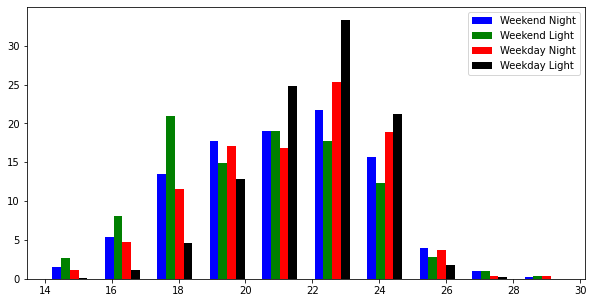

In [16]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours']>=7) & (df['hours']<=22)).astype(int)
df['DayOfWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfWeek']<5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']#Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()

- The above histogram shows that the temperature is comparatively more stable during Week Days in the daylights.

In [17]:
#Now preprocessing the data for LSTM model
df.head()

,timestamp,value,hours,daylight,DayOfWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2


In [18]:
df.dtypes

timestamp     datetime64[ns]
value                float64
hours                  int64
daylight               int64
DayOfWeek              int64
WeekDay                int64
time_epoch             int64
categories             int64
dtype: object

In [19]:
df.columns

Index(['timestamp', 'value', 'hours', 'daylight', 'DayOfWeek', 'WeekDay',
       'time_epoch', 'categories'],
      dtype='object')

-Here we will take the required columns from the dataset and scale it using Standard Scaler. 

In [20]:
data = df[['value', 'hours', 'daylight', 'DayOfWeek', 'WeekDay']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [21]:
data1 = pd.DataFrame(scaled_data)

In [22]:
data1

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


- we will define and initialize the required parameters and define the training and the test data set.
- We are going to learn from 50 previous values and we predict through the LSTM model just the one next value.

In [24]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data1[0:-prediction_time-testdatacut].values
y_train = data1[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data1[0-testdatacut:-prediction_time].values
y_test = data1[prediction_time-testdatacut:  ][0].values

In [25]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [26]:

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [27]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)


x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [30]:
#Building the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.00971364974975586


In [31]:
model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)

Epoch 1/50
2/2 [==============================] - 9s 3s/step - loss: 0.7075 - val_loss: 0.6489
Epoch 2/50
2/2 [==============================] - 5s 2s/step - loss: 0.1967 - val_loss: 0.3064
Epoch 3/50
2/2 [==============================] - 5s 2s/step - loss: 0.1434 - val_loss: 0.2443
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.1239 - val_loss: 0.2261
Epoch 5/50
2/2 [==============================] - 5s 2s/step - loss: 0.1047 - val_loss: 0.2293
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 0.1073 - val_loss: 0.2009
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.0904 - val_loss: 0.1755
Epoch 8/50
2/2 [==============================] - 5s 2s/step - loss: 0.0868 - val_loss: 0.1677
Epoch 9/50
2/2 [==============================] - 5s 2s/step - loss: 0.0837 - val_loss: 0.1612
Epoch 10/50
2/2 [==============================] - 5s 2s/step - loss: 0.0837 - val_loss: 0.1463
Epoch 11/50
2/2 [==============================] 

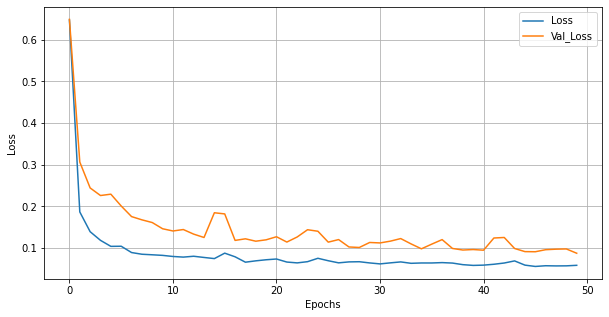

In [32]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [33]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


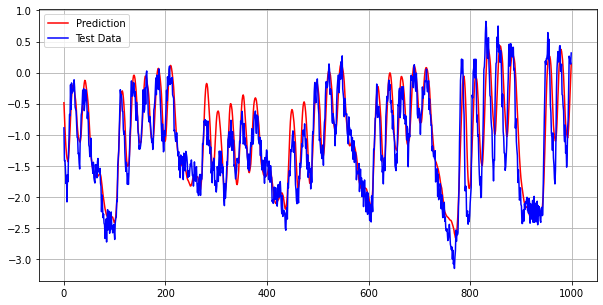

In [34]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

- Now, we are going to find the anomalies. The most distant predicted values are considered as anomalies

In [36]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data1)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


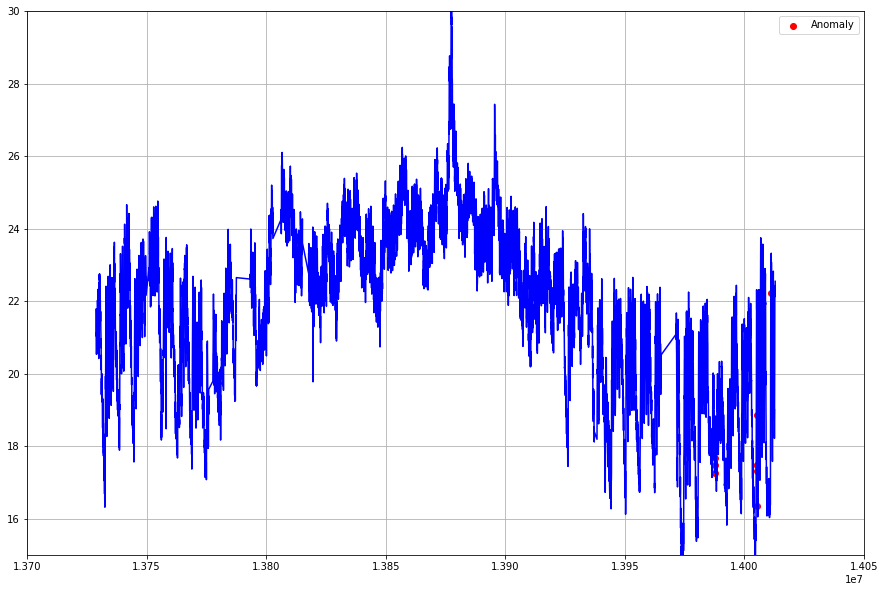

In [37]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()

- As we can see in the above picture, the anomalies are visualized as red points.
-  All the above steps can be repeated multiple times to visualize the anomalies by tuning the hyperparameters.